# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols


## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [2]:
from typing import List, Dict


# Create some class to comfortably save the experiments and their results
class Experiment:
    def __init__(self, name: str):
        """Given the name of the experiment, extract the number of cpu's
        and so on"""
        self._name = name

        # Extract the cpu, batch and njobs by splitting
        parts = name.split('-')
        self.cpu = int(parts[0].replace('cpu', '').strip())
        self.batch = int(parts[1].replace('batch', '').strip())
        self.njobs = int(parts[2].replace('njobs', '').strip())

    # Override the hash function so we can use it as
    # key of the dictionary
    def __hash__(self):
        return self._name

class ExperimentResults:

    def __init__(self, time: float, accuracies: List[float]):
        self.time = time
        self.accuracies = accuracies
        self.final_accuracy = accuracies[-1]


In [3]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())
    network = str(parts[3])[3:] if len(parts) > 3 else 'lenet5'

    return cpu, batch, njobs, network

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication

# This is the path we should change to either analyze the 2k or the full factorial
path_root_master = './experiments/fullfact/master/'

# get the log files
logs = glob.glob(os.path.join(path_root_master, '*.log'))

# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'network': [],
    'time': [],
    'accuracies':[],
    'final_accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)



print(f'Extracting the data from {len(logs)} files')
for log in logs:
    acc = []
    with open(log, 'r') as f:
        for line in f:
            if 'Top1Accuracy is Accuracy' in line:
                try:
                    _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                    acc.append(float(_accuracy.strip()))
                except Exception as e:
                    print('Error while reading accuracy',e)
                if len(acc) == 10:
                    # Then save the time here
                    time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                    break
    # Add the results to the dictionary
    variables = log.split('-')[1:]
    name = '-'.join(variables).replace('.log', '')
    cpu, batch, njobs , network= split_name(name)
    # set all the columns
    results['cpu'].append(cpu)
    results['batch'].append(batch)
    results['njobs'].append(njobs)
    results['network'].append(network)
    results['accuracies'].append(acc)
    results['time'].append(time)
    results['final_accuracy'].append(acc[-1])
    results['exp_name'].append(name)


results_df = pd.DataFrame(results)
# results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df


Extracting the data from 96 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 23402.63 records/second'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/simplenet/20201021_135727'


,exp_name,cpu,batch,njobs,network,time,accuracies,final_accuracy
0,cpu1-batch64-njobs1,1,64,1,lenet,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567
1,cpu2-batch64-njobs1,2,64,1,lenet,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580
2,cpu4-batch256-njobs1,4,256,1,lenet,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288
3,cpu8-batch256-njobs1,8,256,1,lenet,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213
4,cpu1-batch512-njobs1,1,512,1,lenet,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957
...,...,...,...,...,...,...,...,...
91,cpu8-batch256-njobs5-netsimplenet,8,256,5,simplenet,254.219420,"[0.8659, 0.8906, 0.9025, 0.9089, 0.9132, 0.917...",0.9269
92,cpu1-batch512-njobs5-netsimplenet,1,512,5,simplenet,254.219420,"[0.8181, 0.8674, 0.8852, 0.8919, 0.8994, 0.903...",0.9108
93,cpu2-batch512-njobs5-netsimplenet,2,512,5,simplenet,96.711085,"[0.8133, 0.8663, 0.8828, 0.8914, 0.9002, 0.903...",0.9143
94,cpu4-batch512-njobs5-netsimplenet,4,512,5,simplenet,111.249790,"[0.822, 0.8697, 0.8845, 0.8936, 0.8984, 0.9037...",0.9147


In [4]:
results_df.groupby('network').mean()

,cpu,batch,njobs,time,final_accuracy
network,,,,,
lenet,3.75,240.0,3.0,315.457036,0.930652
simplenet,3.75,240.0,3.0,281.989544,0.931669


# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [5]:
def coalesce_metrics(loads, threshold = 1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""
    # Dict to build the dataframe
    avg_loads = {
        'exp_name' :[],
        'cpu_load': [],
        'iowait': [],
        'cpu_mean': [],
        'iowait_mean':[]
    }

    for exp, slaves in loads.items():
        # print(f'\n{exp}')
        count = 0
        list_length = len(list(slaves['slave1'].values())[0])
        c = np.zeros(list_length)
        io = np.zeros(list_length)
        for slave, metrics in slaves.items():

            # if the mean is too slow discard
            cpu_mean = np.mean(metrics['cpu'])
            if  cpu_mean <threshold:
                # print(f'Discarding {slave} with cpu mean =',cpu_mean)
                pass
            else:
                c += metrics['cpu']
                io += metrics['iowait']
                count += 1
                # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                # print(metrics['cpu'])

        # print('dividing by ',count)
        avg_loads['exp_name'].append(exp)
        avg_loads['cpu_load'].append(c / count)
        avg_loads['iowait'].append(io/count)
        avg_loads['cpu_mean'].append(np.mean(c/count))
        avg_loads['iowait_mean'].append(np.mean(io/count))


        # avg_loads[exp] = {
        #     'cpu': c / count,
        #     'iowait': io/count,
        #     'cpu_mean': np.mean(c/count),
        #     'iowait_mean':np.mean(io/count)
        # }

    return avg_loads

In [6]:
root_folder_slaves = './experiments/fullfact/'

dirs = os.listdir(root_folder_slaves)
slave_dirs = [f for f in dirs if 'slave' in f]


loads = defaultdict(dict)
# The shape of the results is
# name of the file:
#     - slave 1:
#         - cpu: list
#         - iowait: list
#     - slave 2:
#         ...

# Do the same in all the folders
for folder in slave_dirs:
    print('Processing files for the', folder)
    # get just the pickle files
    files = glob.glob(os.path.join(root_folder_slaves, folder, '*.pkl'))

    # Extract the dictionary from each file
    for f in files:

        # Get the name of the experiment to index the other dict
        variables = f.split('-')[1:]
        exp_name = '-'.join(variables).replace('.pkl', '')
        # print(exp_name)

        with open(f, 'rb') as pickle_file:
            metrics = pickle.load(pickle_file)

        # Now we need to check to just get the metrics concerning the experiment
        # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
        # to not cut too tightly
        exp_length = results_df.loc[results_df.exp_name == exp_name, 'time'].array[0]
        if exp_length > 300:
            loads[exp_name][folder] = metrics

        else:
            max_list_length = math.ceil(exp_length/2) + 5
            # print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
            if max_list_length < len(metrics['cpu']):
                loads[exp_name][folder] = dict()
                loads[exp_name][folder]['cpu'] = metrics['cpu'][:max_list_length]
                loads[exp_name][folder]['iowait'] = metrics['iowait'][:max_list_length]
            else:
                # Add the whole of it
                loads[exp_name][folder] = metrics

# Get the average usage of the experiments
# The resulting dict will just map each
# pf the experiments to its avg cpu load and
# iowait across all slaves

avg_loads = coalesce_metrics(loads)
loads_df = pd.DataFrame(avg_loads)
loads_df

Processing files for the slave1
Processing files for the slave2
Processing files for the slave3


,exp_name,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
1,cpu2-batch64-njobs1,"[0.0, 0.0, 0.0, 5.55, 6.05, 0.75, 5.45, 7.6, 7...","[0.0, 0.0, 0.0, 0.15, 0.5, 0.0, 1.55, 3.0, 1.4...",3.190667,0.078333
2,cpu4-batch256-njobs1,"[0.0, 0.0, 1.7999999999999998, 11.266666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.5, 1.76666666...",5.596748,0.126016
3,cpu8-batch256-njobs1,"[0.0, 0.0, 2.1666666666666665, 17.966666666666...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.73...",10.900000,0.397561
4,cpu1-batch512-njobs1,"[0.0, 0.0, 0.0, 9.5, 2.6, 2.7, 8.2, 14.6, 18.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 2.6, 0.0, ...",5.808421,0.053684
...,...,...,...,...,...
91,cpu8-batch256-njobs5-netsimplenet,"[0.0, 0.10000000000000002, 0.06666666666666667...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.0,...",35.709524,5.887970
92,cpu1-batch512-njobs5-netsimplenet,"[19.433333333333334, 2.1333333333333333, 2.133...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.070677,0.285714
93,cpu2-batch512-njobs5-netsimplenet,"[0.0, 0.10000000000000002, 0.6, 2.766666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76666666...",17.262346,0.522840
94,cpu4-batch512-njobs5-netsimplenet,"[0.0, 0.0, 0.03333333333333333, 2.933333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0666666666666...",25.111475,2.204372


### Merge the dataframes together so we get a common dataframe for all results


In [7]:
# Merge the two dataframes so we get all the data grouped by experiment number
results_df = results_df.merge(loads_df, on='exp_name')

results_df

,exp_name,cpu,batch,njobs,network,time,accuracies,final_accuracy,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1,1,64,1,lenet,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
1,cpu2-batch64-njobs1,2,64,1,lenet,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580,"[0.0, 0.0, 0.0, 5.55, 6.05, 0.75, 5.45, 7.6, 7...","[0.0, 0.0, 0.0, 0.15, 0.5, 0.0, 1.55, 3.0, 1.4...",3.190667,0.078333
2,cpu4-batch256-njobs1,4,256,1,lenet,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288,"[0.0, 0.0, 1.7999999999999998, 11.266666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.5, 1.76666666...",5.596748,0.126016
3,cpu8-batch256-njobs1,8,256,1,lenet,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213,"[0.0, 0.0, 2.1666666666666665, 17.966666666666...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.73...",10.900000,0.397561
4,cpu1-batch512-njobs1,1,512,1,lenet,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957,"[0.0, 0.0, 0.0, 9.5, 2.6, 2.7, 8.2, 14.6, 18.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 2.6, 0.0, ...",5.808421,0.053684
...,...,...,...,...,...,...,...,...,...,...,...,...
91,cpu8-batch256-njobs5-netsimplenet,8,256,5,simplenet,254.219420,"[0.8659, 0.8906, 0.9025, 0.9089, 0.9132, 0.917...",0.9269,"[0.0, 0.10000000000000002, 0.06666666666666667...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.0,...",35.709524,5.887970
92,cpu1-batch512-njobs5-netsimplenet,1,512,5,simplenet,254.219420,"[0.8181, 0.8674, 0.8852, 0.8919, 0.8994, 0.903...",0.9108,"[19.433333333333334, 2.1333333333333333, 2.133...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11.070677,0.285714
93,cpu2-batch512-njobs5-netsimplenet,2,512,5,simplenet,96.711085,"[0.8133, 0.8663, 0.8828, 0.8914, 0.9002, 0.903...",0.9143,"[0.0, 0.10000000000000002, 0.6, 2.766666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76666666...",17.262346,0.522840
94,cpu4-batch512-njobs5-netsimplenet,4,512,5,simplenet,111.249790,"[0.822, 0.8697, 0.8845, 0.8936, 0.8984, 0.9037...",0.9147,"[0.0, 0.0, 0.03333333333333333, 2.933333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0666666666666...",25.111475,2.204372


## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

### See the relationship with time

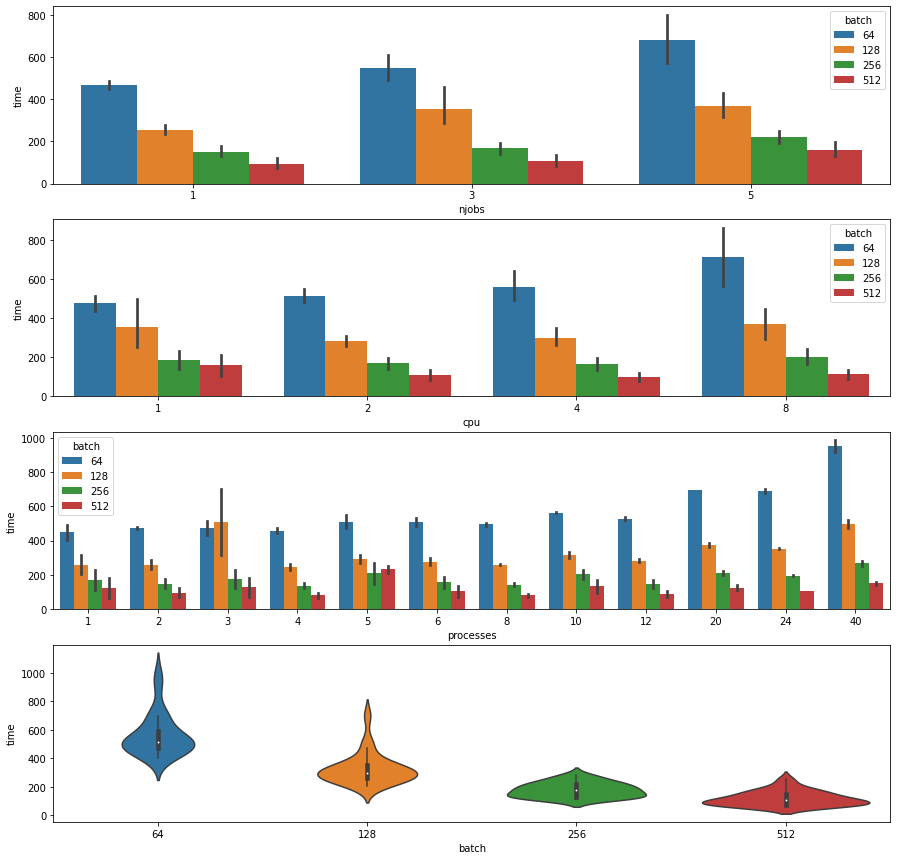

In [99]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='time', hue='batch', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='time', hue='batch', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='time', hue='batch',data=results_df, ax=ax3)
sns.violinplot(x='batch', y='time', data=results_df, ax=ax4);


### See the relationships with the accuracy


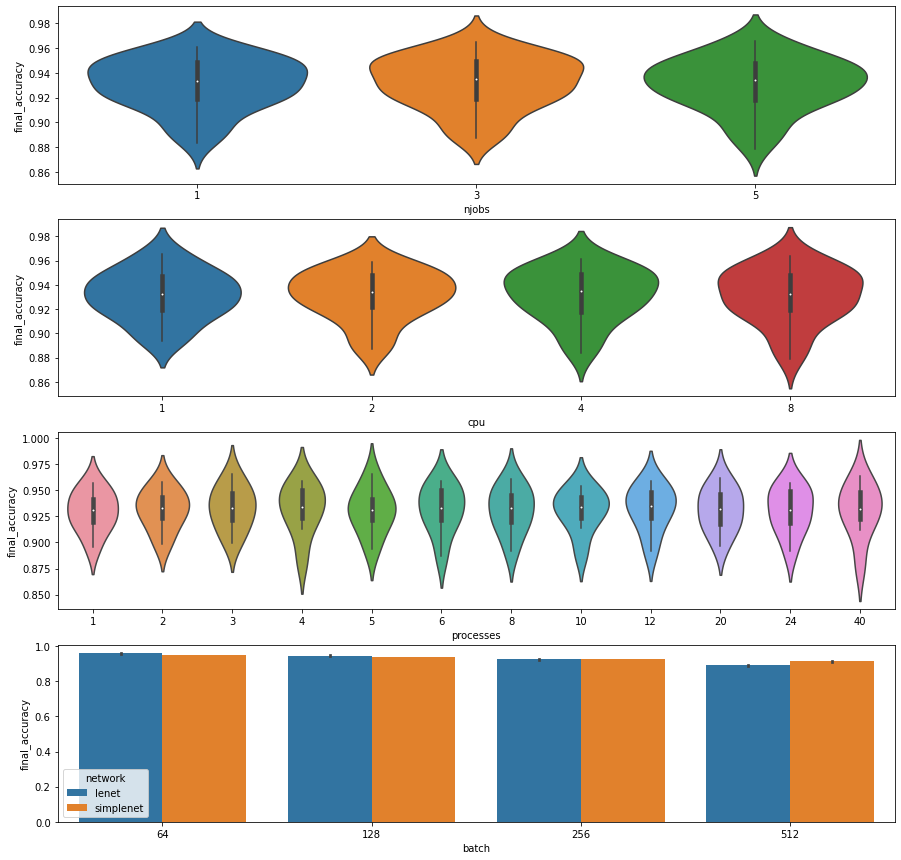

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='final_accuracy', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='final_accuracy', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.violinplot(x='processes', y='final_accuracy', data=results_df, ax=ax3)
sns.barplot(x='batch', y='final_accuracy', hue='network', data=results_df, ax=ax4);


### See the relationship with the cpu load and iowait

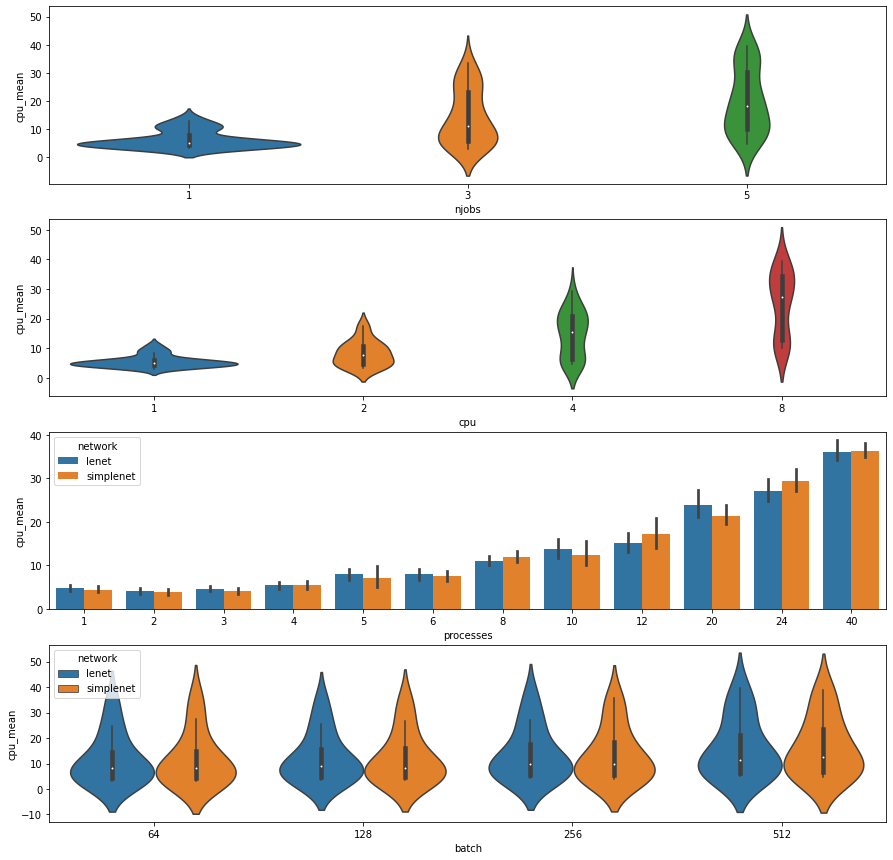

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='cpu_mean', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='cpu_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='cpu_mean', hue='network', data=results_df, ax=ax3)
sns.violinplot(x='batch', y='cpu_mean', hue = 'network', data=results_df, ax=ax4);




,cpu,batch,time,final_accuracy,cpu_mean,iowait_mean,proc,processes
njobs,,,,,,,,
1,3.75,240.0,242.454891,0.930934,6.423209,0.152696,3.75,3.75
3,3.75,240.0,295.294573,0.931913,14.149430,0.904313,11.25,11.25
5,3.75,240.0,358.420407,0.930634,19.861862,2.175779,18.75,18.75


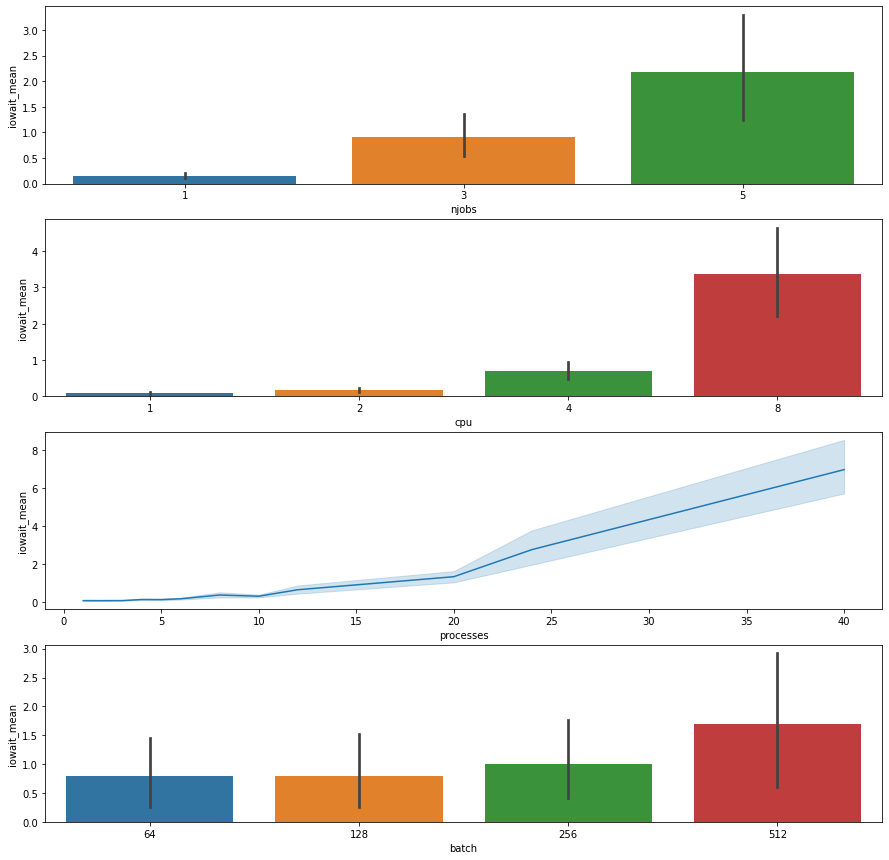

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='iowait_mean', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='iowait_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.lineplot(x='processes', y='iowait_mean', data=results_df, ax=ax3)
sns.barplot(x='batch', y='iowait_mean', data=results_df, ax=ax4);


results_df.groupby('njobs').mean()

## Run some statistical tests to see if the batch influences any of the outputs

In [8]:
# run for batch with the IO, CPU...

from scipy.stats import mannwhitneyu
import itertools

def njobs_significance_test(column: str):

    print('Starting jobs significance test for column', column)

    # Divide in batches
    n0 = results_df[results_df.njobs == 1][column]
    n1 = results_df[results_df.njobs == 3][column]
    n2 = results_df[results_df.njobs == 5][column]

    jobs = {1: n0,
               3:n1,
               5:n2
    }

    # Calculate p-values
    combinations = itertools.combinations(list(jobs.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(jobs[i], jobs[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

def cpu_significance_test(column: str):

    print('Starting cpu significance test for column', column)

    # Divide in batches
    c0 = results_df[results_df.cpu == 1][column]
    c1 = results_df[results_df.cpu == 2][column]
    c2 = results_df[results_df.cpu == 4][column]
    c3 = results_df[results_df.cpu == 8][column]

    cpus = {1: c0,
               2:c1,
               4:c2,
               8:c3
    }

    # Calculate p-values
    combinations = itertools.combinations(list(cpus.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(cpus[i], cpus[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()


def batch_significance_test(column: str):

    print('Starting batch significance test for column', column)

    # Divide in batches
    b0 = results_df[results_df.batch == 64][column]
    b1 = results_df[results_df.batch == 128][column]
    b2 = results_df[results_df.batch == 256][column]
    b3 = results_df[results_df.batch == 512][column]

    batches = {64: b0,
               128:b1,
               256:b2,
               512:b3
    }

    # Calculate p-values
    combinations = itertools.combinations([64,128,256,512], 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(batches[i], batches[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

for col in ['time', 'final_accuracy', 'cpu_mean', 'iowait_mean']:
    print(f'--------- {col.upper()} ------------')
    batch_significance_test(col)
    njobs_significance_test(col)
    cpu_significance_test(col)

--------- TIME ------------
Starting batch significance test for column time
P-value of 64 and 128 is 1.2677958766051596e-07 --> RELEVANT
P-value of 64 and 256 is 1.5258408287505792e-09 --> RELEVANT
P-value of 64 and 512 is 1.5243462714137668e-09 --> RELEVANT
P-value of 128 and 256 is 3.8933481497524654e-08 --> RELEVANT
P-value of 128 and 512 is 2.510648038061492e-09 --> RELEVANT
P-value of 256 and 512 is 0.00010259273711841342 --> RELEVANT

Starting jobs significance test for column time
P-value of 1 and 3 is 0.13395962545866563 --> NON_RELEVANT
P-value of 1 and 5 is 0.011425140606952615 --> RELEVANT
P-value of 3 and 5 is 0.10463106018059959 --> NON_RELEVANT

Starting cpu significance test for column time
P-value of 1 and 2 is 0.2783695249891529 --> NON_RELEVANT
P-value of 1 and 4 is 0.2513730934210644 --> NON_RELEVANT
P-value of 1 and 8 is 0.40627452724409946 --> NON_RELEVANT
P-value of 2 and 4 is 0.4385463432859047 --> NON_RELEVANT
P-value of 2 and 8 is 0.21363945308598808 --> NON_R

## Try to calculate the service rate of the disk based on the number of jobs and the batch

In [35]:
Tcpu = 0.045
mu_cpu = 1/Tcpu
num_examples = 60000
num_epochs = 10

# Surprisingly, the batch size doesn't influence cpu utilization??
serv_df = results_df.groupby(['batch', 'njobs']).mean()
display(serv_df)

mus = {
    'batch':[],
    'njobs':[],
    'mu':[]
}

for (batch, njobs) , row in serv_df.iterrows():
    # Calculate the new numbers
    l_disk = njobs * mu_cpu
    T = row.time
    Nt = (num_examples/batch) * num_epochs
    mu_disk = (1/((T/Nt) - Tcpu)) + l_disk
    
    mus['batch'].append(batch)
    mus['njobs'].append(njobs)
    mus['mu'].append(mu_disk)

    
df_mu = pd.DataFrame(mus)

df_mu

cpu        time  final_accuracy   cpu_mean  iowait_mean   proc
batch njobs                                                                 
64    1      3.75  468.621367        0.954100   5.519028     0.105347   3.75
      3      3.75  549.722318        0.954638  12.087444     0.578861  11.25
      5      3.75  680.756922        0.954812  17.817361     1.722194  18.75
128   1      3.75  256.083148        0.941475   5.800136     0.093548   3.75
      3      3.75  355.678648        0.943825  12.943425     0.582427  11.25
      5      3.75  369.372507        0.940713  18.342436     1.724999  18.75
256   1      3.75  150.582501        0.925162   6.606478     0.153725   3.75
      3      3.75  169.310548        0.926150  14.511490     0.887506  11.25
      5      3.75  222.786779        0.925638  19.756877     1.976099  18.75
512   1      3.75   94.532546        0.903000   7.767193     0.258166   3.75
      3      3.75  106.466777        0.903038  17.055361     1.568458  11.25
      5      3.75  160.765422        0.901375  23.530775     3.279824  18.75

,batch,njobs,mu
0,64,1,222.772566
1,64,3,139.996324
2,64,5,147.324532
3,128,1,126.052827
4,128,3,99.052067
5,128,5,140.697376
6,256,1,74.174231
7,256,3,103.378509
8,256,5,131.088859
9,512,1,50.258736


We see that the service rate stabilizes at around 125-130 rps


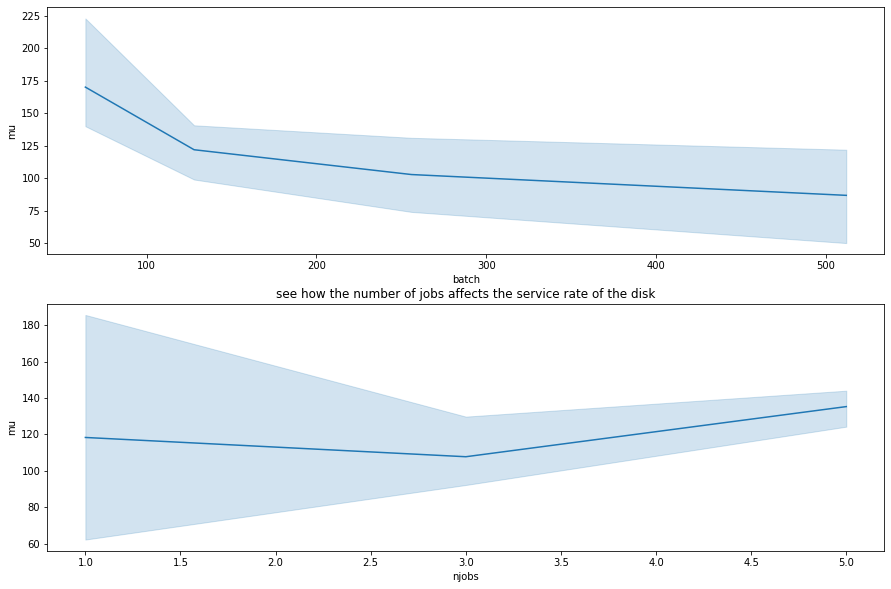

In [36]:
f, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))

plt.title('see how the number of jobs affects the service rate of the disk')
sns.lineplot(x='batch', y='mu', data=df_mu, ax=ax1)
sns.lineplot(x='njobs', y='mu', data=df_mu, ax=ax2)

print('We see that the service rate stabilizes at around 125-130 rps')

In [37]:
# Try to fit a linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# print((X[:,0]**2).shape)
X = df_mu[['batch', 'njobs']].values
# print((X[:,0]**2).shape)
# X = np.hstack((X, (X[:,0]**2).reshape(-1,1), (X[:,1]**2).reshape(-1,1)))


l = LinearRegression()
l.fit(X, df_mu['mu'])

display(l.intercept_, l.coef_)

# so the best line of how it varies --> mu = -0.15 * batch + 4.23 * njobs + 145

# get the parameters

coef_batch, coef_jobs = l.coef_
intercept = l.intercept_


# mean_squared_error(y_pred, df_mu['mu'])


145.01710093681055

array([-0.15539907,  4.23819331])

In [38]:
def get_mu_disk(batch, jobs):
    return coef_batch * batch + coef_jobs * jobs  + intercept

# Take the mean of the mu as 120
print('Get the predictions of the response time based on the batch and number of jobs')
# Total time = Ncycles * (E(Tcpu) + E(t_disk)) 
Tcpu = 0.045
mu_cpu = 1/Tcpu

res = {
    'expected':[],
    'actual':[]
}

for (batch, njobs), row in serv_df.iterrows():
    # Measured time
    T_true = row.time
    
    # Apply the formula
    l_disk = njobs * mu_cpu
    mu_disk = get_mu_disk(batch, njobs)
    Nt = (num_examples/batch) * num_epochs
    Tdisk = 1/(mu_disk - l_disk)
    
    T = Nt * (Tcpu + Tdisk)
#     print(f'[Batch {batch}, Njobs {njobs}]--> Expected: {T}, Actual {T_true}')
    res['expected'].append(T)
    res['actual'].append(T_true)

    
res = pd.DataFrame(res)    
    
res
    

Get the predictions of the response time based on the batch and number of jobs


,expected,actual
0,501.943303,468.621367
1,537.445276,549.722318
2,629.509685,680.756922
3,254.687854,256.083148
4,276.797286,355.678648
5,344.082890,369.372507
6,132.330934,150.582501
7,151.171161,169.310548
8,258.507045,222.786779
9,77.421670,94.532546


## Run the ANOVA tests on this data 

We want to see how factors like number of CPUs, Jobs, and Batch influence all the others
- Accuracy
- E(T)
- CPU Usage
- IO Wait

In [9]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the cpu, batch and njobs columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs', df).fit()
        
    else:
        if y not in ['final_accuracy', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs', 'cpu_mean', 'iowait_mean']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [39]:
# Simply change the output value for the y to the variable that you want to study
# - iowait_mean
# - final_accuracy
# - time
# - cpu_mean
res, model = ANOVA(results_df, y='iowait_mean', verbose=True)
res

c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


N     Mean      SD      SE  95% Conf.  Interval
cpu batch njobs                                                 
1   64    1      2   0.0997  0.0995  0.0703    -0.7940    0.9933
          3      2   0.0389  0.0082  0.0058    -0.0345    0.1123
          5      2   0.0797  0.0024  0.0017     0.0585    0.1008
    128   1      2   0.0385  0.0125  0.0089    -0.0740    0.1510
          3      2   0.0666  0.0272  0.0192    -0.1777    0.3108
          5      2   0.0807  0.0028  0.0020     0.0552    0.1061
    256   1      2   0.0583  0.0029  0.0021     0.0321    0.0844
          3      2   0.0685  0.0189  0.0133    -0.1010    0.2380
          5      2   0.1138  0.0276  0.0195    -0.1340    0.3616
    512   1      2   0.0666  0.0182  0.0129    -0.0973    0.2305
          3      2   0.0923  0.0299  0.0212    -0.1765    0.3611
          5      2   0.1946  0.1288  0.0911    -0.9625    1.3518
2   64    1      2   0.0552  0.0328  0.0232    -0.2392    0.3495
          3      2   0.1038  0.0248  0.0176    -0.1193    0.3268
          5      2   0.2252  0.0083  0.0059     0.1504    0.3000
    128   1      2   0.0432  0.0025  0.0018     0.0207    0.0656
          3      2   0.1093  0.0051  0.0036     0.0638    0.1548
          5      2   0.2013  0.0088  0.0062     0.1223    0.2804
    256   1      2   0.0561  0.0132  0.0094    -0.0627    0.1749
          3      2   0.1737  0.0095  0.0067     0.0886    0.2588
          5      2   0.2923  0.0088  0.0062     0.2131    0.3716
    512   1      2   0.0980  0.0293  0.0207    -0.1655    0.3615
          3      2   0.2627  0.0684  0.0484    -0.3520    0.8775
          5      2   0.4669  0.0792  0.0560    -0.2446    1.1783
4   64    1      2   0.0839  0.0445  0.0314    -0.3157    0.4834
          3      2   0.3876  0.0525  0.0371    -0.0840    0.8591
          5      2   0.9926  0.0712  0.0503     0.3530    1.6321
    128   1      2   0.0737  0.0136  0.0096    -0.0482    0.1956
          3      2   0.3463  0.0323  0.0228     0.0564    0.6362
          5      2   0.9129  0.0355  0.0251     0.5938    1.2320
    256   1      2   0.1282  0.0030  0.0021     0.1009    0.1554
          3      2   0.7001  0.0248  0.0175     0.4775    0.9227
          5      2   1.3353  0.0221  0.0156     1.1365    1.5341
    512   1      2   0.2042  0.0015  0.0010     0.1912    0.2173
          3      2   1.1153  0.0883  0.0625     0.3218    1.9089
          5      2   2.0583  0.2065  0.1460     0.2026    3.9140
8   64    1      2   0.1827  0.0145  0.0102     0.0528    0.3126
          3      2   1.7852  0.2833  0.2003    -0.7603    4.3307
          5      2   5.5913  0.2816  0.1991     3.0614    8.1213
    128   1      2   0.2188  0.0904  0.0639    -0.5934    1.0310
          3      2   1.8076  0.4211  0.2978    -1.9761    5.5912
          5      2   5.7051  0.6289  0.4447     0.0551   11.3551
    256   1      2   0.3724  0.0356  0.0252     0.0526    0.6922
          3      2   2.6077  0.3520  0.2489    -0.5553    5.7706
          5      2   6.1629  0.3888  0.2749     2.6694    9.6565
    512   1      2   0.6638  0.1329  0.0940    -0.5304    1.8581
          3      2   4.8034  0.4747  0.3356     0.5387    9.0682
          5      2  10.3995  0.4805  0.3397     6.0827   14.7163

Overall model F( 7, 88) =  167.940, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            iowait_mean   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     167.9
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           4.36e-48
Time:                        14:41:51   Log-Likelihood:                -77.436
No. Observations:                  96   AIC:                             170.9
Df Residuals:                      88   BIC:                             191.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4139      0.357      1.158      0.250      -0.296       1.124
cpu                -0.2061      0.078     -2.659      0.009      -0.360      -0.052
batch               0.0002      0.001      0.184      0.855      -0.002       0.003
cpu:batch          -0.0001      0.000     -0.567      0.572      -0.001       0.000
njobs              -0.2737      0.105     -2.616      0.010      -0.482      -0.066
cpu:njobs           0.1557      0.023      6.861      0.000       0.111       0.201
batch:njobs        -0.0005      0.000     -1.501      0.137      -0.001       0.000
cpu:batch:njobs     0.0004   7.69e-05      4.669      0.000       0.000       0.001
==============================================================================
Omnibus:                        3.986   Durbin-Watson:                   2.296
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                4.695
Skew:                           0.076   Prob(JB):                       0.0956
Kurtosis:                       4.073   Cond. No.                     3.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,sum_sq,df,F,PR(>F)
cpu,161.604101,1.0,504.095341,3.424296e-38
batch,12.561594,1.0,39.183664,1.368175e-08
cpu:batch,17.520422,1.0,54.651850,7.913631e-11
njobs,65.485824,1.0,204.271419,1.166373e-24
cpu:njobs,107.705186,1.0,335.967230,8.557450e-32
batch:njobs,5.002474,1.0,15.604332,1.571080e-04
cpu:batch:njobs,6.989999,1.0,21.804061,1.076056e-05
Residual,28.211252,88.0,NaN,NaN


In [ ]:
model.params

In [ ]:
(X[:,0]*X[:,1]).reshape(-1,1).shape

In [31]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

from sklearn.model_selection import GridSearchCV, train_test_split

x_train, x_test, y_train_acc, y_test_acc = train_test_split(X, y_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,1000, 2000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([[-0.93045745, -1.02575529,  1.        ],
       [-0.83968112, -1.02575529,  1.        ],
       [-0.65812844,  0.09325048,  1.        ],
       [-0.2950231 ,  0.09325048,  1.        ],
       [-0.93045745,  1.58525817,  1.        ],
       [-0.83968112,  1.58525817,  1.        ],
       [-0.65812844,  1.58525817,  1.        ],
       [-0.2950231 ,  1.58525817,  1.        ],
       [-0.74890478, -1.02575529,  1.        ],
       [-0.47657577, -1.02575529,  1.        ],
       [ 0.06808225, -1.02575529,  1.        ],
       [ 1.1573983 , -1.02575529,  1.        ],
       [-0.65812844, -1.02575529,  1.        ],
       [-0.74890478, -0.65275337,  1.        ],
       [-0.47657577, -0.65275337,  1.        ],
       [ 0.06808225, -0.65275337,  1.        ],
       [ 1.1573983 , -0.65275337,  1.        ],
       [-0.74890478,  0.09325048,  1.        ],
       [-0.47657577,  0.09325048,  1.        ],
       [ 0.06808225,  0.09325048,  1.        ],
       [ 1.1573983 ,  0.09325048,  1.   

LinearRegression() -2.1074726777581722e-05
Lasso(alpha=1) -0.0004350320289721093
Ridge() -2.1321564610011425e-05
DecisionTreeRegressor(max_depth=20) -2.0876511111111105e-05
RandomForestRegressor(criterion='mae', max_depth=4, n_estimators=50) -1.3479058364444307e-05
298.72329023590623 [  55.58951826 -146.60037323   16.7337462 ]


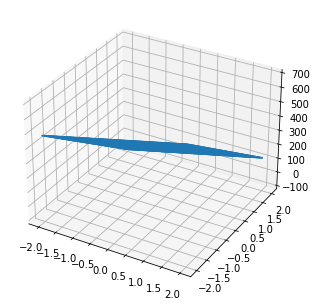

In [111]:
# Scale the data

%matplotlib inline

# PLot the datapoints
from mpl_toolkits.mplot3d import Axes3D

# plot the train examples
f = plt.figure()
ax = Axes3D(f)
# print(xtrain.shape, y.ravel().shape)
# ax.scatter(xtrain[:,0], xtrain[:,1], y, c='r')

X2 = np.hstack((X, (X[:,0]*X[:,1]).reshape(-1,1), (X[:,0]*X[:,2]).reshape(-1,1), (X[:,1]*X[:,2]).reshape(-1,1), (X[:,0]*X[:,1]*X[:,2]).reshape(-1,1)))

# Fit a simple linear regression
regressors = [LinearRegression(), Lasso(alpha=1), Ridge(), DecisionTreeRegressor(max_depth=20), RandomForestRegressor(n_estimators=50, criterion='mae', max_depth=4)]

# Try with second order stats

# xtrain_2 = np.concatenate((xtrain, xtrain**2, xtrain**3), axis =1)
# print(xtrain_2)

for r in regressors:
    loo = LeaveOneOut()

    scores = cross_validate(r, X2, y_acc, cv=10, scoring='neg_mean_squared_error')

    print(r,np.mean(scores['test_score']))


x1,x2 = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))

lr = regressors[0].fit(X, y_time)
inter = lr.intercept_
coefs = lr.coef_

y_out = coefs[0]*x1+coefs[1]*x2 + inter
print(inter, coefs)
ax.plot_wireframe(x1,x2,y_out);

In [106]:
(X[:,0]*X[:,1]).reshape(-1,1).shape

(96, 1)

In [32]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

from sklearn.model_selection import GridSearchCV, train_test_split

x_train, x_test, y_train_acc, y_test_acc = train_test_split(X, y_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,1000, 2000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

Fitting the time...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:   58.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting the accuracy
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done 296 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 808 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1160 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=8,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(4, 10),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 150, 200, 500, 1000, 2000]},
             verbose=3)

In [33]:
cv_time.best_params_

{'criterion': 'mae',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 50}

In [34]:
cv_acc.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 50}

### Fit the regressors on the accuracy and time

In [36]:
from sklearn.metrics import mean_squared_error

# 1) Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for TIME', err)


# 2) Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for ACCURACY', err)

Mean Squared Error with the test set is for TIME 1597.7368579880053
Mean Squared Error with the test set is for ACCURACY 1.8683460366070817e-05


In [ ]:
# Run some examples with it

## Create the Final Optimizer that will multiplex the regressors seen above

In [42]:
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_validate


from typing import Tuple, Optional
# Declare the class for the ML model

from dataclasses import dataclass

@dataclass
class Job:
    cpu:int
    njobs: int
    network: int


class Courier:
    """ Courier has 3 parameters to account for utilization, accuracy and response time,
    based on which, and their weights, it chooses the optimal batch size for the task

    labels are in format dict
    accuracy -> labels
    time -> labels
    utilization -> labels
    """

    def __init__(self, alpha: float, beta: float,
                models: dict, scaler, batches=[64,128,256,512]):


        self.batches = np.array(batches).reshape(len(batches), 1)
        

        if alpha + beta !=1:
            raise ValueError('The hyperparameters need to add up to 1')

        # Configure the hyperparams and the training data
        self.alpha = alpha
        self.beta = beta
        
        
        self.scaler = scaler

        # Compute the predictors
        self.acc_model = models['accuracy']
        self.time_model = models['time']

    def optimize(self, job: Job, latency = None):
        acc, t = self._predict(job)
        
        b = self.batches


        if latency:
            # Just take the options that satisfy the requirements
            fit = t[t<latency]
            if len(fit) == 0:
                print('Not a single value fulfills the '
                      'time requirements, selecting minimum time')
                # Return the minimum time
                min_t_idx = np.where(t == t.min())[0][0]
                return self.batches[min_t_idx], (acc[min_t_idx],
                                                 t[min_t_idx])

            else:
                acc = acc[t<latency]
                b = self.batches[t<latency]
                t = t[t<latency]


        # Return the batch that better fulfills the requirements and
        # also return a tuple with the predictions
        sc_a = acc/np.max(acc)
        sc_t = 1-( t/np.max(t))

        sc = self.alpha * sc_a + self.beta * sc_t

        # Get the index of the max score
        max_sc_idx = np.where(sc == sc.max())[0][0]
        return  b[max_sc_idx], (acc[max_sc_idx],
                                           t[max_sc_idx])



    def _fit_model(self, labels):
        """Fit the model to particular labels"""
        reg = self.model
        reg.fit(self.X, labels)
        return reg


    def _preprocess_data(self, X):
        """Standardizes the data"""
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def _predict(self, job: Job):
        """Predicts the time, accuracy and util with different batches
        and returns the best one given the optims"""

        acc = []
        t = []
        
        # predict the performance of the job with different batches
        for b in self.batches:
            data_point = self.scaler.transform([[job.cpu * job.njobs, b, job.network]])
            _acc = self.acc_model.predict(data_point)
            _t = self.time_model.predict(data_point)
            print(f'Batch {b}, acc = {_acc} and t = {_t}')

            acc.append(_acc)
            t.append(_t)


        return np.array(acc), np.array(t)




In [46]:
# Create the Courier

c = Courier(alpha = 0.98, beta=0.02, 
            models= {
                'accuracy': r_acc,
                'time': r_t
},
           scaler=scaler)

In [47]:
# Get some predidctions from the Courier

j = Job(cpu = 10, njobs=8, network=-1)
batch, prediction = c.optimize(j, latency=400)

print(f'Recommended batch {batch}, predictions {prediction}')

Batch [64], acc = [0.94840507] and t = [914.11793623]
Batch [128], acc = [0.93838265] and t = [409.66707557]
Batch [256], acc = [0.92522572] and t = [181.82810604]
Batch [512], acc = [0.91284016] and t = [127.20340717]
Recommended batch 256, predictions (0.9252257197159567, 181.82810603513997)


## Run the ANOVA test with all of the results


In [ ]:



# Get the last accuracy instead of the list for the accuracy of each of the experiments

df = pd.DataFrame(res_final)

df